# Studying a Federated System

Following on from our work creating a federated system using CNN as a model, this jupyter file was created to play around with a federated system and get different results

Importing Section

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn import metrics
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random
import csv
import timeit
from timeit import default_timer as timer

Obtaining training and testing data

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

All of the functions needed to run the code, see the previous document for more information on how each function was created

In [49]:
def splittingData(x_train,y_train,x_test,y_test,noClients):
    trainLen = len(x_train)
    clientSize = trainLen/noClients
    
    x_train_clients = []
    y_train_clients = []
    x_test_clients = []
    y_test_clients = []
    
    x_train_splits = np.array_split(x_train,noClients)
    y_train_splits = np.array_split(y_train,noClients)
    x_test_splits = np.array_split(x_test,noClients)
    y_test_splits = np.array_split(y_test,noClients)
    
    for i in range(noClients):
        x_train_clients.append(x_train_splits[i])
        y_train_clients.append(y_train_splits[i])
        x_test_clients.append(x_test_splits[i])
        y_test_clients.append(y_test_splits[i])
    
    return x_train_clients, y_train_clients, x_test_clients, y_test_clients

def createModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    return model

def trainModels(numClients):
    models = []
    for i in range(numClients):
        print("Creating Model {0}".format(i))
        model = createModel()
        model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
        model.fit(x_train_clients[i], y_train_clients[i], epochs=10, verbose=0)
        models.append(model)
    print("Creating Total Model")
    model = createModel()
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=10, verbose=0)
    
    return models, model

def createZeroWeightCNN():
    layer1 = [np.zeros(shape = (3,3,3,32), dtype = 'float32'), np.zeros(shape = 32, dtype = 'float32')]
    layer2 = [np.zeros(shape = (3,3,32,64), dtype = 'float32'), np.zeros(shape = 64, dtype = 'float32')]
    layer3 = [np.zeros(shape = (10816,64), dtype = 'float32'), np.zeros(shape = (64), dtype = 'float32')]
    layer4 = [np.zeros(shape = (64,10), dtype = 'float32'), np.zeros(shape = (10), dtype = 'float32')]

    testModel = models.Sequential()
    testModel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    testModel.add(layers.MaxPooling2D((2, 2)))
    testModel.add(layers.Conv2D(64, (3, 3), activation='relu'))
    testModel.add(layers.Flatten())
    testModel.add(layers.Dense(64, activation='relu'))
    testModel.add(layers.Dense(10))
    
    testModel.layers[0].set_weights(layer1)
    testModel.layers[2].set_weights(layer2)
    testModel.layers[4].set_weights(layer3)
    testModel.layers[5].set_weights(layer4)
    testModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return testModel

def fedAvg(models_,fedModel,numClients):
    layers_ = []
    layers_.append(models_[0].layers[0].weights)
    layers_.append(models_[0].layers[2].weights)
    layers_.append(models_[0].layers[4].weights)
    layers_.append(models_[0].layers[5].weights)
    layersNums = [0,2,4,5]    
    
    for x in range(len(layersNums)):
        for y in range(len(layers_[x])):
            layers_[x][y] = layers_[x][y]/numClients

    for n in range(1,numClients):
        count = 0
        for i in layersNums:
            for j in range(len(models_[0].layers[i].weights)):
                layers_[count][j] = layers_[count][j] + (models_[n].layers[i].weights[j]/numClients)
            count += 1
    count = 0
    for i in layersNums:
        for j in range(len(models_[0].layers[i].weights)):
            layers_[count][j] = (layers_[count][j] + fedModel.layers[i].weights[j])/2
        count += 1
    fedModel.layers[0].set_weights(layers_[0])
    fedModel.layers[2].set_weights(layers_[1])
    fedModel.layers[4].set_weights(layers_[2])
    fedModel.layers[5].set_weights(layers_[3])
    return fedModel

def trainModelsFed(numClients, noEpochs,writer,NC):
    row = []
    fedModel = createZeroWeightCNN()
    models = []
    for i in range(numClients):
        model = createModel()
        model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
        models.append(model)
        
    start = timer()
    for i in range(numClients):
        models[i].fit(x_train_clients[i], y_train_clients[i], epochs=1, verbose=0)
    fedModel = fedAvg(models,fedModel,numClients)
    testModelsFed(0,fedModel,numClients,writer,start,NC)
    
    for ep in range(1,noEpochs):
        start = timer()
        for i in range(numClients):
            models[i] = fedModel
            models[i].fit(x_train_clients[i], y_train_clients[i], epochs=1, verbose=0)
        fedModel = fedAvg(models,fedModel,numClients)
        testModelsFed(ep,fedModel,numClients,writer,start,NC)

    return fedModel, models

def testModelsFed(ep,model,numClients,writer,start,NC):
    fedAcc = 0
    row = [numClients, ep+1,0,0]
    for i in range (NC):
        row.append(0)
    for i in range(numClients):
        loss, acc = model.evaluate(x_test_clients[i],  y_test_clients[i], verbose=0)
        fedAcc += acc/numClients
        row[4+i] = acc
    end = timer()
    #print("Accuracy at Epoch {0} is = {1}".format(ep,fedAcc))
    row[2] = fedAcc
    row[3] = end-start
    writer.writerow(row)

Create the models here

In [50]:
os.environ['PYTHONHASHSEED']=str(2)
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)
NC = 10
f = open('./FCNNResults.csv', 'w', newline = '')
header = ['NumClients', 'NumEpochs','FTA','Time']
clients = []
for i in range(NC):
    header.append("LAN{0}".format(i))
    clients.append(i+1)
writer = csv.writer(f)
writer.writerow(header)
noEpochs = 10
for nc in range(1,NC+1):
    x_train_clients, y_train_clients, x_test_clients, y_test_clients = splittingData(train_images, train_labels, test_images, test_labels, nc)
    print("Running a federated system with {0} clients".format(nc))
    fedModel, finalLocalModels = trainModelsFed(nc, noEpochs, writer, NC)
f.close()

Running a federated system with 1 clients
Accuracy at Epoch 0 is = 0.5005000233650208
Accuracy at Epoch 1 is = 0.6297000050544739
Accuracy at Epoch 2 is = 0.6481000185012817
Accuracy at Epoch 3 is = 0.6600000262260437
Accuracy at Epoch 4 is = 0.6712999939918518
Accuracy at Epoch 5 is = 0.670199990272522
Accuracy at Epoch 6 is = 0.6729999780654907
Accuracy at Epoch 7 is = 0.6665999889373779
Accuracy at Epoch 8 is = 0.6618000268936157
Accuracy at Epoch 9 is = 0.6424999833106995
Running a federated system with 2 clients
Accuracy at Epoch 0 is = 0.17149999737739563
Accuracy at Epoch 1 is = 0.5954999923706055
Accuracy at Epoch 2 is = 0.6116999983787537
Accuracy at Epoch 3 is = 0.6375000178813934
Accuracy at Epoch 4 is = 0.6574000120162964
Accuracy at Epoch 5 is = 0.6666999757289886
Accuracy at Epoch 6 is = 0.6666000187397003
Accuracy at Epoch 7 is = 0.6601999998092651
Accuracy at Epoch 8 is = 0.6545000076293945
Accuracy at Epoch 9 is = 0.6410000026226044
Running a federated system with 3 cl

Plot and compare results here

In [103]:
data = pd.read_csv('./FCNNResults.csv',
                   sep=',',
                   header=0,
                   )

In [124]:
Accs = data.iloc[:,2]
NodeAccs = data.iloc[:,4:]
finalAccs = []
for i in range(NC):
    finalAccs.append(data.iloc[(10*i)-1][2])

In [209]:
plt.figure(1)
plt.plot(clients,finalAccs)
plt.title("Final Accuracy for varying number of clients in a federated system")
plt.xlabel('Number of Clients')
plt.ylabel('Accuracy')
plt.xticks(clients)
plt.savefig('Images/FinalTimesNumClients.png')
plt.close()

In [161]:
fAccPC = np.array_split(Accs,NC)

In [204]:
plt.figure(2)
for i in range(NC):
    plt.plot(clients,fAccPC[i],label = "{0} clients".format(i+1))
plt.title("Accuracy at each Epoch for varying numbers of clients")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(clients)
plt.savefig('Images/EpochTimesNumClients.png')
plt.close()

In [205]:
nodeAcc = np.array_split(NodeAccs,NC,axis = 1)
nodeAccs = []
for i in range(NC):
    nodeAccs.append(np.array_split(nodeAcc[i],NC))

In [206]:
plt.figure(3)
for i in range(NC):
    plt.plot(clients,nodeAccs[0][i],label = "{0} Clients".format(i+1))
plt.title("Local Accuracy on node one for each number of clients")
plt.xlabel('Number of clients')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(clients)
plt.savefig('Images/EpochTimesPerClients.png')
plt.close()

In [211]:
plt.figure(4)
plt.plot(clients,nodeAccs[0][0])
plt.title("Local Accuracy on node one for one client")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(clients)
plt.savefig('Images/EpochTimesNodeOne.png')
plt.close()

In [210]:
plt.figure(4)
plt.plot(clients,nodeAccs[9][9])
plt.title("Local Accuracy on node ten for ten clients")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(clients)
plt.savefig('Images/EpochTimesNodeTen.png')
plt.close()

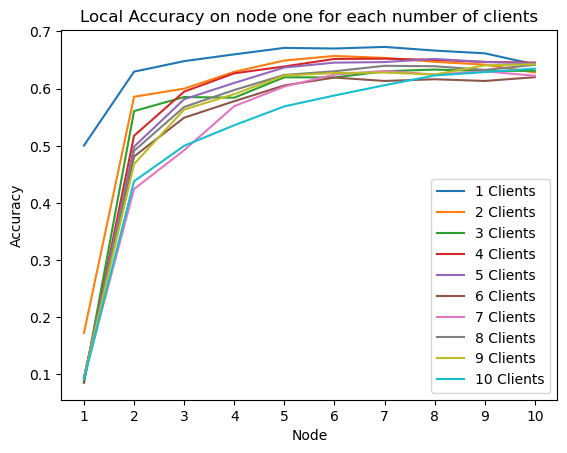

In [215]:
plt.figure(5)
for i in range(NC):
    plt.plot(clients,nodeAccs[i][i],label = "{0} Clients".format(i+1))
plt.title("Local Accuracy on node one for each number of clients")
plt.xlabel('Node')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(clients)
plt.savefig('Images/AccuracyNoClients.png')